In [1]:
# dependencies import
from common_dependencies import *

In [2]:
def draw_map(data_map):
    with plt.style.context('dark_background'):
            fig, ax = plt.subplots()
        
            fig.set_figwidth(18)
            fig.set_figheight(8)
            fig.patch.set_alpha(0.0)
        
            ax.invert_yaxis()
            ax.xaxis.tick_top()
            ax.xaxis.set_label_position('top')
            ax.set_title("Предсказанная развернутая карта дефектов", fontsize=25)
            ax.set_xlabel('Номер датчика', fontsize=20)
            ax.set_ylabel('Номер измерения', fontsize=20)
            ax.tick_params(axis='both', labelsize = 20)

            map = ax.pcolormesh(data_map)
            cbar = fig.colorbar(map)
            cbar.ax.tick_params(labelsize=20)

            ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
    
    plt.show()

In [3]:
# paths for files with original data
PATH_TO_DATA = {
    'run_1': 
        ('data/original_data/run_1/run1_WM32_data.csv',
        'data/original_data/run_1/run1_WM32_defects.csv',
        'data/original_data/run_1/run1_WM32_pipe.csv'),
    'run_2':
        ('data/original_data/run_2/run2_WM32_data.csv',
        'data/original_data/run_2/run2_WM32_defects.csv',
        'data/original_data/run_2/run2_WM32_pipe.csv')
}

PATH_TO_MODEL = 'networks/CNN'

CROP_SIZE = 16
CROP_STEP = 1
RUN = 1
MODEL_VER = '04'
MODEL_NUM = '02'
XSHIFT = 200

for name in os.listdir(PATH_TO_MODEL):
    res = re.match(F'(id=v{MODEL_VER}n{MODEL_NUM}).*', name)
    if not res is None:
        PATH_TO_MODEL += '/' + res[0]
        break

# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)

In [4]:
# Загрузка модели
load_model = keras.models.load_model(PATH_TO_MODEL)

In [5]:
def make_pred_fast(model, 
                   path_to_data_tuple: tuple(),
                   x_shift: int,
                   crop_size: int, 
                   crop_step: int):

    x_df, y_df = dw.get_x_and_y_data(*path_to_data_tuple)
    x_df = dw.roll_df(x_df, x_shift, axis=1)
    y_df = dw.roll_df(y_df, x_shift, axis=1)
    
    or_rows = x_df.shape[0]
    or_cols = x_df.shape[1]

    ex_x_df = dw.extend_df_for_prediction(x_df, crop_size, crop_step)
    ex_x_df = dw.extend_df_for_crops_dividing(ex_x_df, crop_size, crop_step)
    
    ex_y_df = dw.extend_df_for_prediction(y_df, crop_size, crop_step)
    ex_y_df = dw.extend_df_for_crops_dividing(ex_y_df, crop_size, crop_step)

    ex_rows = ex_x_df.shape[0]
    ex_cols = ex_x_df.shape[1]
    
    (x_data_time,
    x_data_amp) = dw.reshape_x_df_to_image_like_numpy(ex_x_df, crop_size, crop_step)

    x_data_time = dw.standartize_data(x_data_time)
    x_data_amp = dw.standartize_data(x_data_amp)

    res = model.predict([x_data_time, x_data_amp])[:,0]

    extend_arr = np.ones((ex_rows, ex_cols))     
    
    res_it = iter(res) 
    
    for j in range(0,  ex_cols - crop_size + 1, crop_step):
        for i in range(0, ex_rows - crop_size + 1, crop_step):  
            temp_add = next(res_it)
            if temp_add >= 0.5:
                extend_arr[i:i+crop_size, j:j+crop_size] += temp_add
            else:
                extend_arr[i:i+crop_size, j:j+crop_size] -= temp_add 
    

    left_up_border = crop_size - 1
    
    orig_arr = extend_arr[left_up_border:, left_up_border:][:or_rows, :or_cols]

    extend_df = pd.DataFrame(data=extend_arr, 
                             columns=ex_x_df.columns, 
                             index=ex_x_df.index)

    orig_df = pd.DataFrame(data=orig_arr, 
                       columns=x_df.columns.tolist(), 
                       index=x_df.index.tolist())
    
    return orig_df, extend_df, y_df, ex_y_df, orig_arr, extend_arr 

In [6]:
orig_df, extend_df, \
ref_orig_df, ref_extend_df, \
orig_arr, extend_arr = make_pred_fast(load_model, PATH_TO_DATA['run_1'], XSHIFT, CROP_SIZE, CROP_STEP)

||||||||||||||||||
Original data reading
Read detectors data shape: (115, 400)
Read defect data shape: (115, 400)
||||||||||||||||||

||||||||||||||||||
extend_df_for_prediction
input df shape:  (115, 400) -> output shape:  (145, 430)
||||||||||||||||||

||||||||||||||||||
extend_df_for_crops_dividing
input df shape:  (145, 430) -> output shape:  (145, 430)
||||||||||||||||||

||||||||||||||||||
extend_df_for_prediction
input df shape:  (115, 400) -> output shape:  (145, 430)
||||||||||||||||||

||||||||||||||||||
extend_df_for_crops_dividing
input df shape:  (145, 430) -> output shape:  (145, 430)
||||||||||||||||||

||||||||||||||||||
X df reshaping to 4D
Original df size:  (145, 430)
Crop windows height/width:  16
Crop windows step across rows and cols:  1
New x_time shape:  (53950, 16, 16, 32)
New x_amp shape:  (53950, 16, 16, 32)
||||||||||||||||||

||||||||||||||||||
Data standartizing
arr_max before standartize: 44.5
arr_min before standartize: 0.0
arr_max after standartize: 1.0

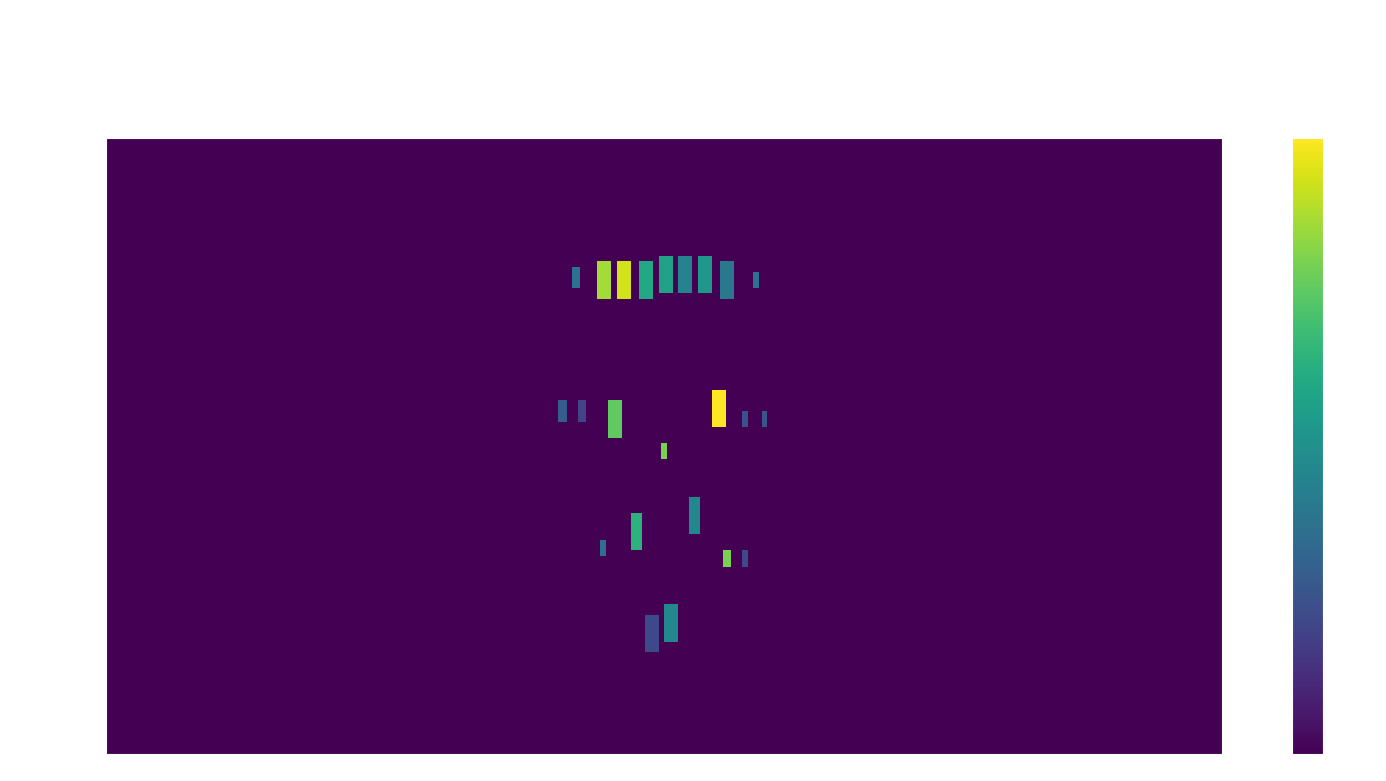

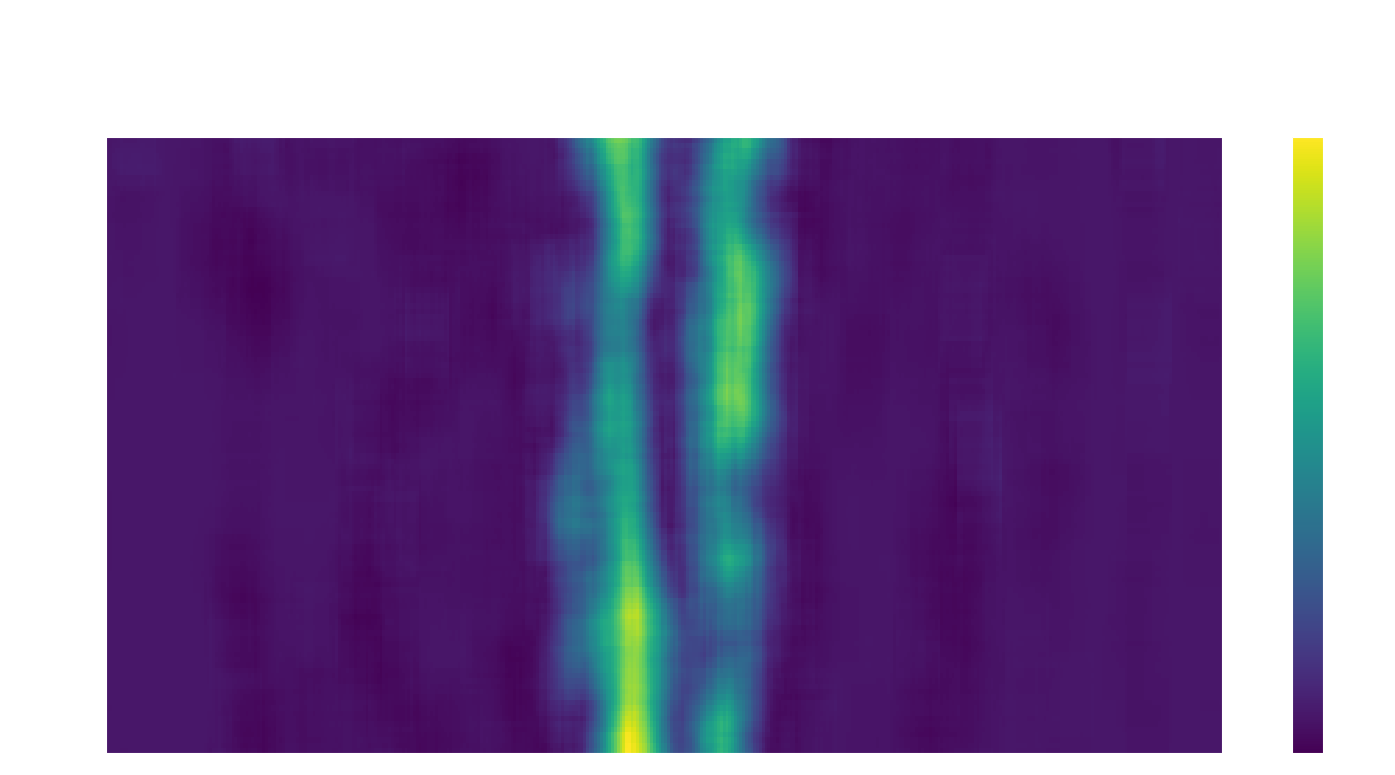

In [7]:
dw.draw_defects_map(ref_orig_df, title=f'Эталонная карта дефектов')
dw.draw_defects_map(orig_df, title=f'Предсказанная карта дефектов')

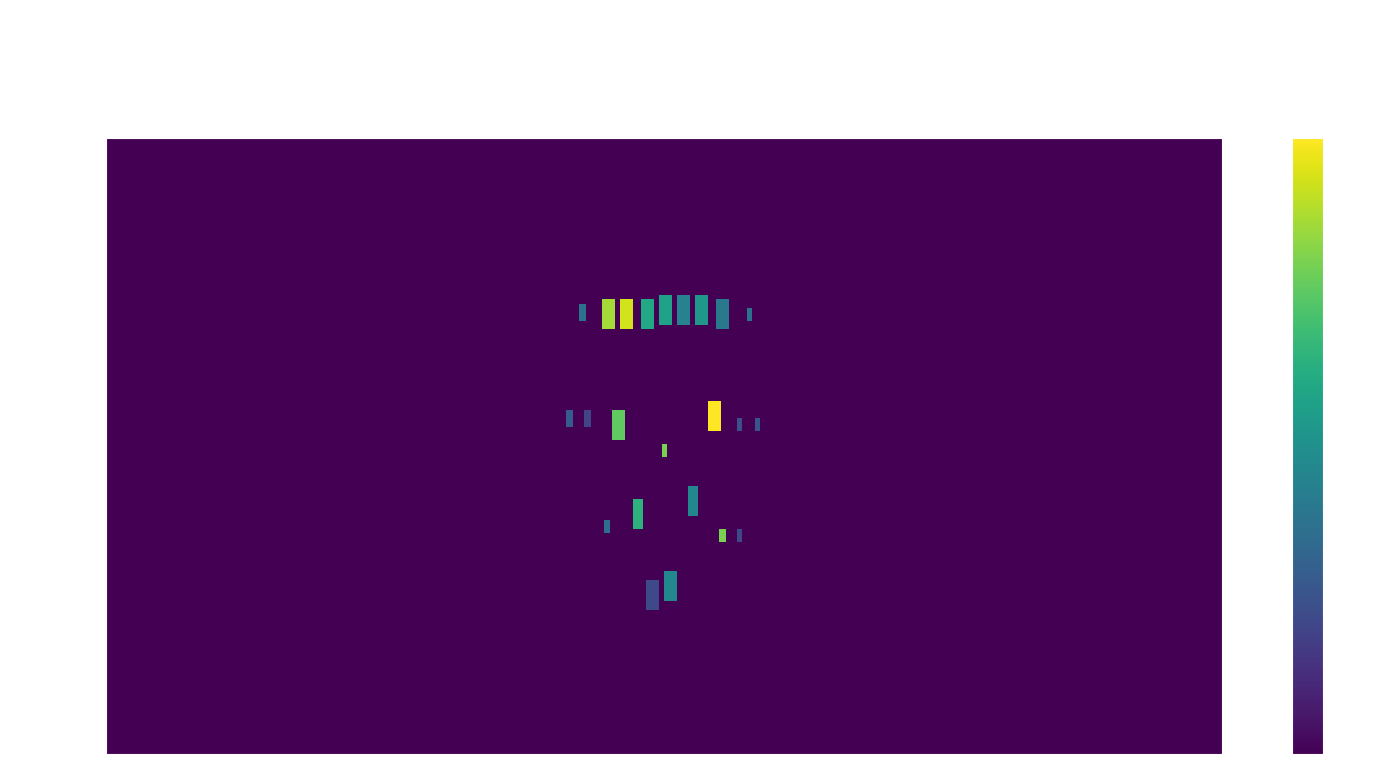

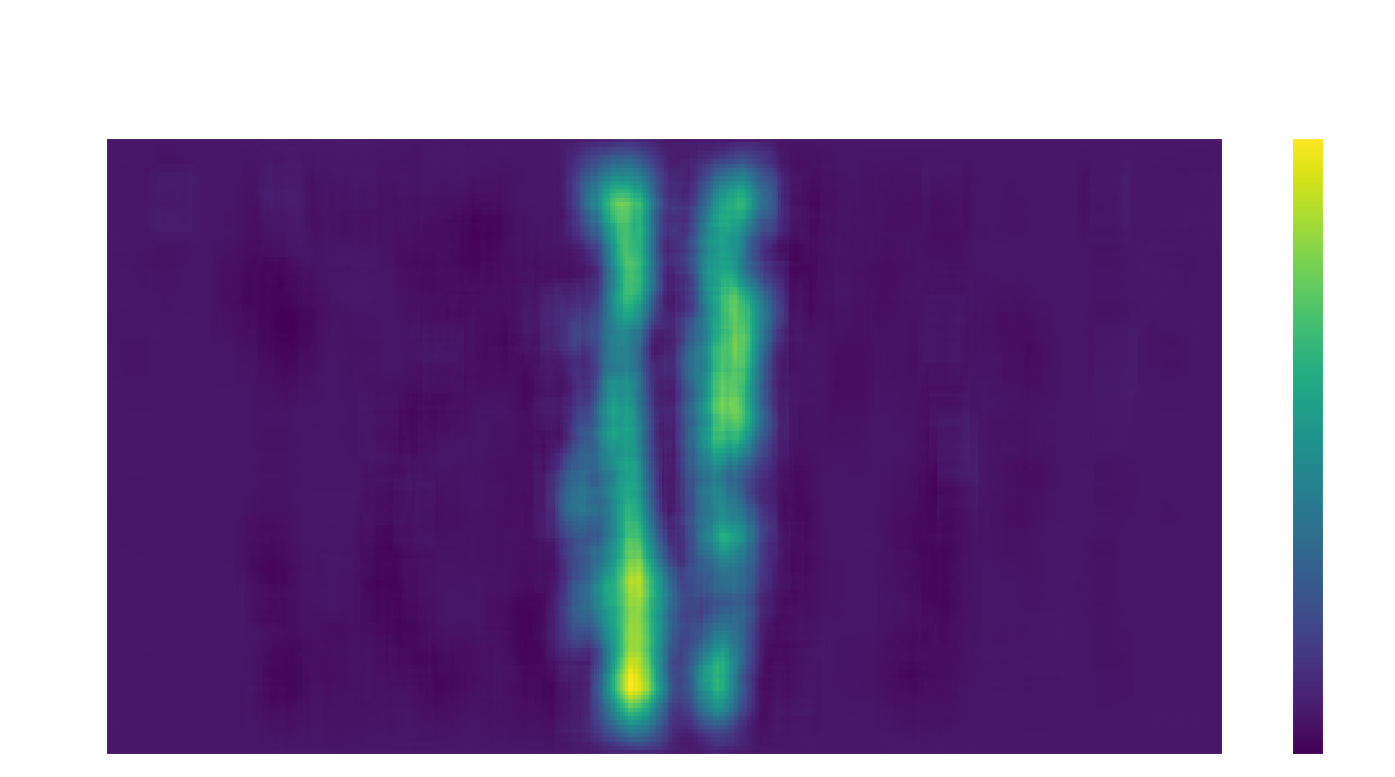

In [8]:
dw.draw_defects_map(ref_extend_df, title=f'Расширенная эталонная карта дефектов')
dw.draw_defects_map(extend_df, title=f'Расширенная предсказанная карта дефектов')

In [9]:
path_to_run = f'data/drawing_data/model_id=v{MODEL_VER}n{MODEL_NUM}/run_{RUN}/' 
res_file_name = f'model_id=v{MODEL_VER}n{MODEL_NUM}_crop(size={CROP_SIZE},step={CROP_STEP})_shift(x={XSHIFT},y=0).xlsx'

if not os.path.exists(path_to_run):
    os.makedirs(path_to_run)

with pd.ExcelWriter(os.path.join(path_to_run, res_file_name)) as writer:  
    orig_df.to_excel(writer, sheet_name='orig_res')
    extend_df.to_excel(writer, sheet_name='extend_res')
    
    ref_orig_df.to_excel(writer, sheet_name='orig_reference')
    ref_extend_df.to_excel(writer, sheet_name='extend_reference')